In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import numpy as np
from csbdeep.utils import normalize
import sys
from pathlib import Path
from PIL import Image

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualize Fellin Dataset
In this notebook we're going to load the "goo_example" of the Fellin dataset, then, since the computing nodes I am using are very limited, I am going to extract samples for each `tiff` recording. The dataset comprises 3 versions of the same footage:
1. *Raw* measurements
2. *Motion corrected* processed
3. *Cleaned* version obtained using DeepCad

In [6]:
dataset='../dataset/dati_per_erzelli/mini2p_astro/good_example/2024Feb06-007'
sample_dir='../dataset/sample'
raw_file=f'{dataset}/raw_data/tSer_00001.tif'
motion_corrected_file=f'{dataset}/motion_corrected/M2P_astro_OF_001_concatenate_corrected_aligned.tiff'
denoised_file=f'{dataset}/denoised/M2P_astro_OF_001_concatenate_corrected_alignedf_E_05_Iter_6048_output.tif'

## Extract Samples

### 1. Raw measurement

In [ ]:
# 3m
raw_tiff = tiff.imread(raw_file).astype(np.float32)

In [ ]:
frames=raw_tiff.shape[0]
for i in range(0, frames, frames//20):
    np.save(open(f'{sample_dir}/raw/fellin_{i}.npy','wb'), raw_tiff[i])

### 2. Motion corrected

In [ ]:
# 4m
motion_corrected_tiff = tiff.imread(motion_corrected_file).astype(np.float32)

In [ ]:
frames=raw_tiff.shape[0]
for i in range(0, frames, frames//20):
    np.save(open(f'{sample_dir}/motion_corrected/fellin_{i}.npy','wb'), motion_corrected_tiff[i])

### 3. Denoised with DeepCAD
> Note: the deepCAD file is 3 times longer than the first two ($10,120$ against $3,360$).

In [3]:
denoised_tiff = tiff.imread(denoised_file).astype(np.float32)

In [ ]:
frames=raw_tiff.shape[0]
for i in range(0, frames, frames//20):
    np.save(open(f'{sample_dir}/deepcad/fellin_{i}.npy','wb'), denoised_tiff[i])

### Overview of the extracted samples

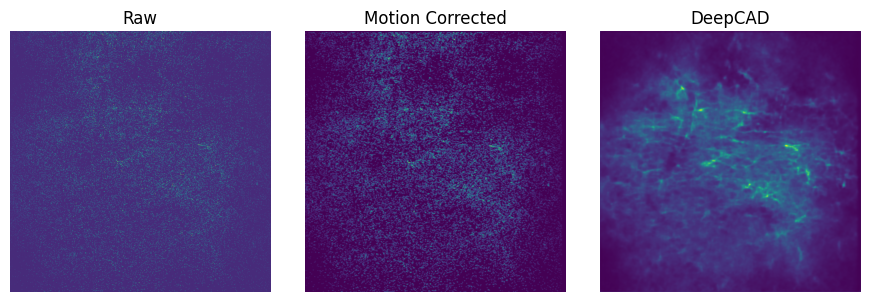

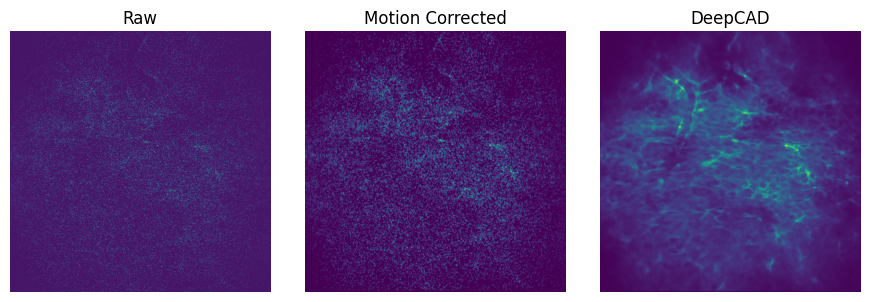

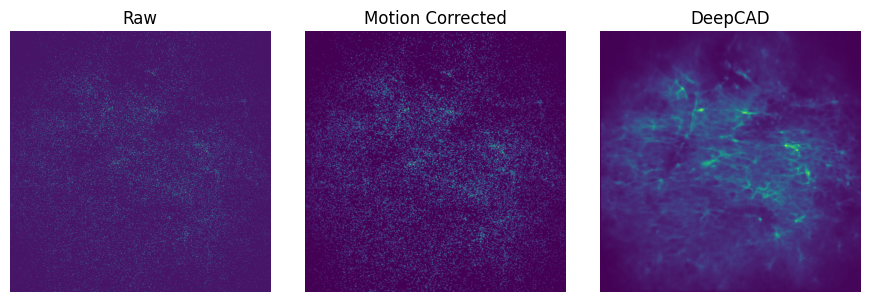

In [36]:
for i in [0, 1008, 2016]:
    raw = np.load(open(f"{sample_dir}/raw/fellin_{i}.npy", "rb"))
    motion_corrected = np.load(open(f"{sample_dir}/motion_corrected/fellin_{i}.npy", "rb"))
    deepcad = np.load(open(f"{sample_dir}/deepcad/fellin_{i}.npy", "rb"))
    imshow({"Raw": raw, "Motion Corrected": motion_corrected, "DeepCAD": deepcad}, size=3)

## BM3D denoising

In [ ]:
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
import bm3d
import cv2

In [8]:
SAMPLE = 0

The values must be ranged 0-1 because `sigma_psd` depends on it.

In [9]:
motion_corrected = np.load(open(f"{sample_dir}/motion_corrected/fellin_{SAMPLE}.npy", "rb"))
motion_corrected /= np.max(motion_corrected)
deepcad = np.load(open(f"{sample_dir}/deepcad/fellin_{SAMPLE}.npy", "rb"))
deepcad /= np.max(deepcad)

In [10]:
# 18s
bm3D_all = bm3d.bm3d(motion_corrected, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES)
Image.fromarray(bm3D_all*255).convert("RGB").save(f"{sample_dir}/bm3d/fellin_{SAMPLE}_all.png")

In [11]:
# 10s
bm3D_hard = bm3d.bm3d(motion_corrected, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
Image.fromarray(bm3D_hard*255).convert("RGB").save(f"{sample_dir}/bm3d/fellin_{SAMPLE}_hard.png")

In [12]:
bm3D_all = np.array(Image.open(f"{sample_dir}/bm3d/fellin_{SAMPLE}_all.png").convert("L"))
bm3D_hard = np.array(Image.open(f"{sample_dir}/bm3d/fellin_{SAMPLE}_hard.png").convert("L"))

In [30]:
psnr=peak_signal_noise_ratio((deepcad*255).astype(np.uint), bm3D_all, data_range=255)
ssim=structural_similarity((deepcad*255).astype(np.uint), bm3D_all, data_range=255)
cprint('PSNR','red:(DeepCAD - BM3D_AllStages)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM3D_AllStages)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM3D_AllStages) --> 20.13dB
SSIM (DeepCAD - BM3D_AllStages) --> 0.572


In [ ]:
psnr=peak_signal_noise_ratio((deepcad*255).astype(np.uint), bm3D_hard, data_range=255)
ssim=structural_similarity((deepcad*255).astype(np.uint), bm3D_hard, data_range=255)
cprint('PSNR','red:(DeepCAD - BM3D_HardThresholding)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM3D_HardThresholding)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM3D_HardThresholding) --> 19.75dB
SSIM (DeepCAD - BM3D_HardThresholding) --> 0.594


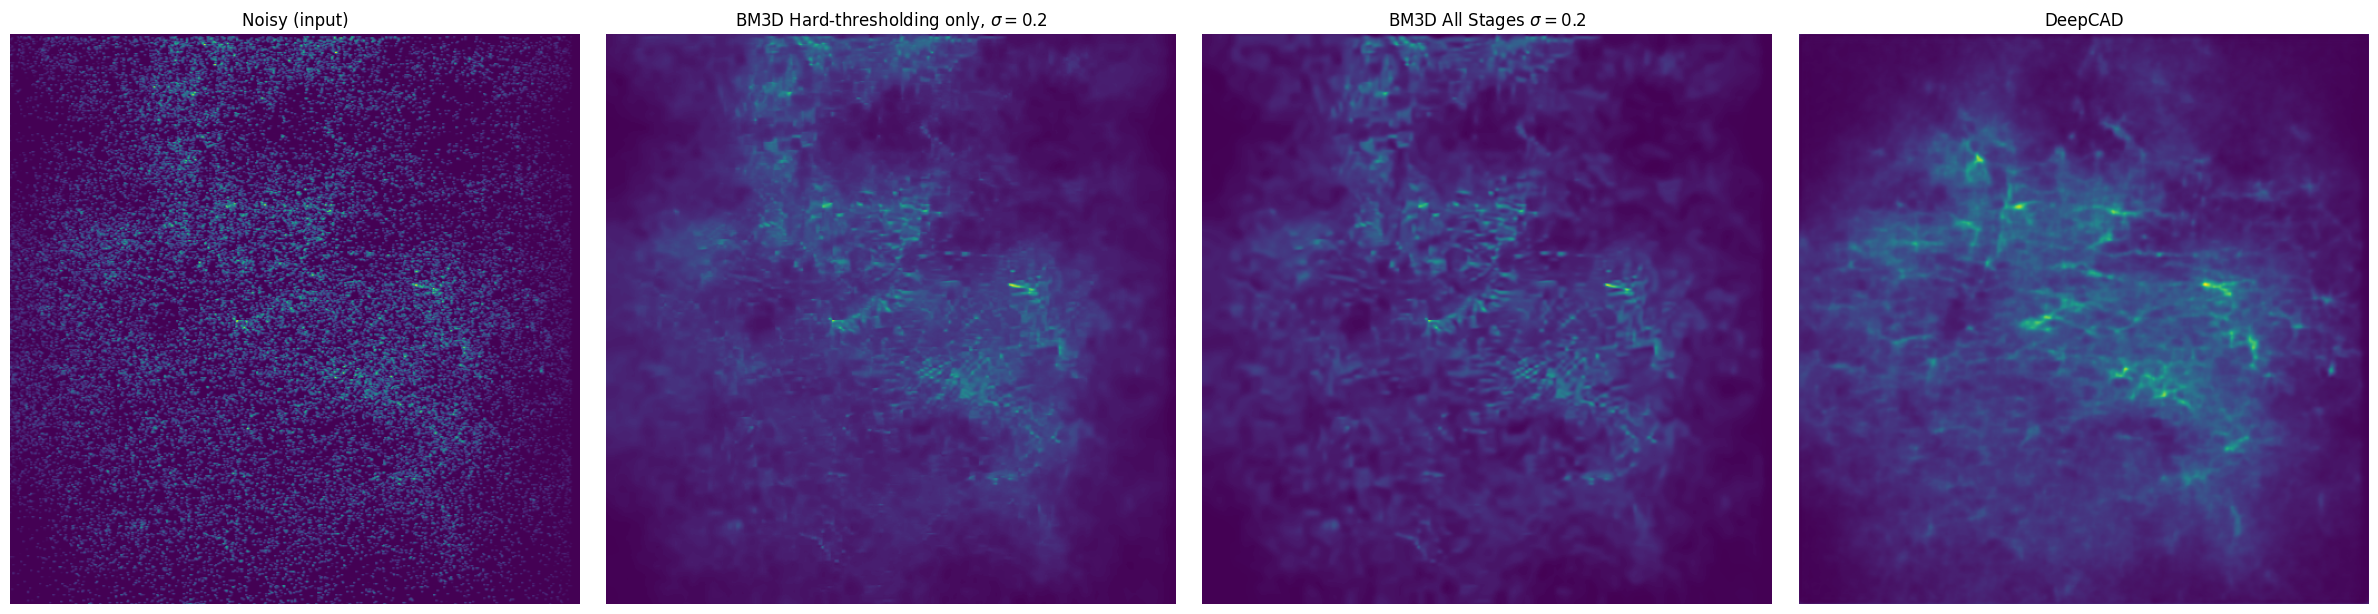

In [38]:
imshow(
    {
        "Noisy (input)": motion_corrected,
        "BM3D Hard-thresholding only, $\sigma=0.2$": bm3D_hard,
        "BM3D All Stages $\sigma=0.2$": bm3D_all,
        "DeepCAD": deepcad,
    },
    size=6,
)

BM3D is meant to be used with natural images. It does not perform well with neuroscience images.